# Overview

This Jupyter notebook will explore and implement essential statistical concepts used in data analysis, inference, and conclusion drawing. We'll work through practical implementations of these statistical methods using Python, demonstrating their applications in real-world scenarios.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import stats
from matplotlib.dates import DateFormatter
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime
from IPython.display import display

# Roulette Simulation and Profit Analysis

Roulette is a popular casino game played with a wheel that has numbered slots colored red,
black, or green. In American roulette, the wheel has 38 slots: 18 red slots, 18 black slots, and
2 green slots labeled "0" and "00".

Players can place various types of bets, including betting on whether the outcome will be a
red or black slot. In this exercise, we focus on a simple bet: betting on black.

If you place a bet on black and the outcome is indeed black, you win and double your money.
However, if the outcome is red or green, you lose the amount you bet. For example, if you bet
1 dollar on black and win, you gain 1 dollar. If you lose, you forfeit your 1-dollar bet.

## Simulation Roulette

Here we've implemented a simulate_roulette(N) function that simulates N rounds of betting on black in American roulette and returns the total earnings.

In [2]:
ROULETTE_BLACK=1
ROULETTE_WHITE=0
ROULETTE_GREEN=-1
ROULETTE_P_BLACK=18/38
ROULETTE_P_WHITE=18/38
ROULETTE_P_GREEN=2/38
ROULETTE_WIN_AMOUNT=1
ROULETTE_LOSS_AMOUNT=-1

In [3]:
def simulate_roulette(N):
    outcomes = np.random.choice(
        [ROULETTE_BLACK, ROULETTE_WHITE, ROULETTE_GREEN],
        size=N,
        p=[ROULETTE_P_BLACK, ROULETTE_P_WHITE, ROULETTE_P_GREEN]
      )
    earnings = np.where(
        outcomes == ROULETTE_BLACK,
        ROULETTE_WIN_AMOUNT,
        ROULETTE_LOSS_AMOUNT
      )
    return np.sum(earnings)

## Monte Carlo Simulation

In [4]:
def plot_distribution(results, N_values, title, xlabel, precision):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, N in enumerate(N_values):
        ax = axes[i]
        earnings = results[N]

        sns.histplot(earnings, kde=True, ax=ax)

        mean = np.mean(earnings)
        std = np.std(earnings)

        x = np.linspace(min(earnings), max(earnings), 100)
        y = stats.norm.pdf(x, mean, std)
        scaling_factor = len(earnings) * (max(earnings) - min(earnings)) / 100
        ax.plot(x, y * scaling_factor, 'r-', linewidth=2, label='Normal Distribution')

        title_type = title
        xlabel = xlabel
        ax.set_title(f'Distribution of {title_type} for N={N}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Frequency')

        ax.axvline(mean, color='g', linestyle='--', label=f'Mean: {mean:.{precision}f}')
        ax.text(0.05, 0.95,
                f'Mean: {mean:.{precision}f}\nStd Dev: {std:.{precision}f}',
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.legend()

    plt.tight_layout()
    plt.show()

In [5]:
N_values = [10, 25, 100, 1000]

### $S_N$ (total_earnings)

For the Monte Carlo simulation of total earnings, I've created visualizations showing the distribution of total earnings for N = 10, 25, 100, and 1000, with 100,000 simulations for each case. The histograms include normal distribution curves for comparison.

In [6]:
def monte_carlo_total_earnings(N, num_simulations=100000):
    total_earnings = np.zeros(num_simulations)

    for i in range(num_simulations):
        total_earnings[i] = simulate_roulette(N)

    return total_earnings

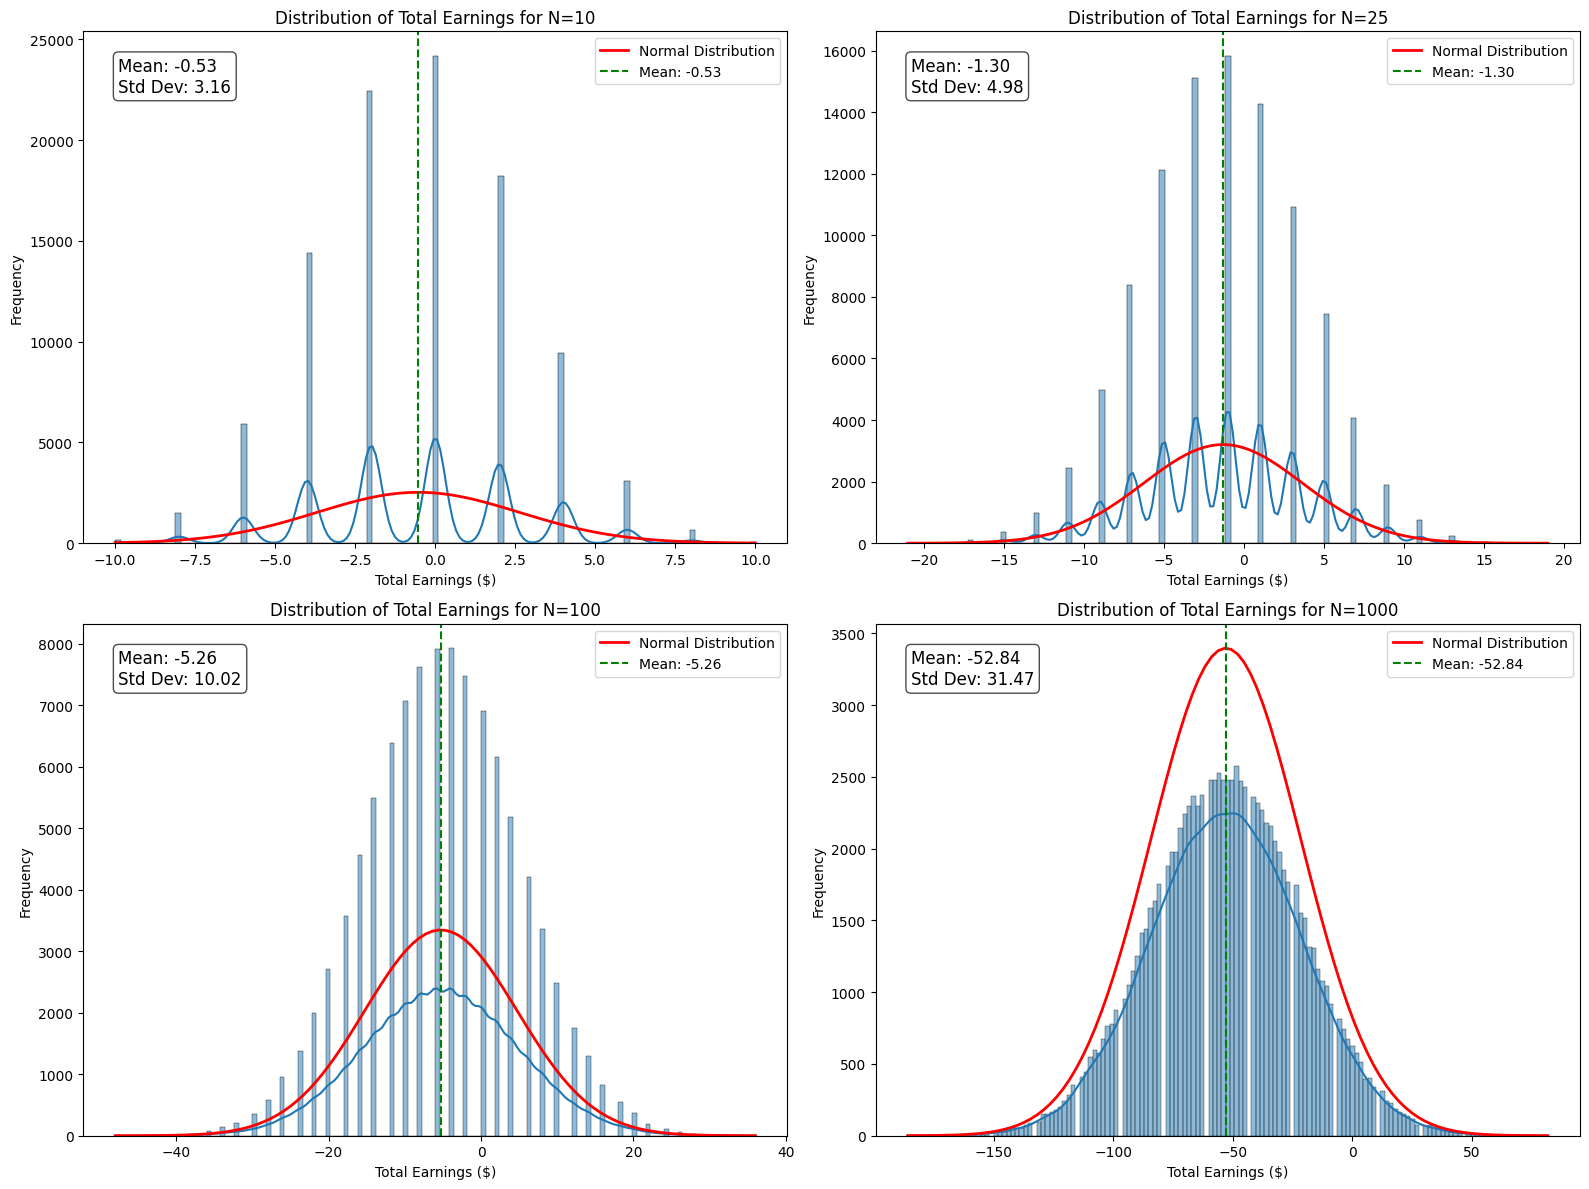

In [7]:
N_values = [10, 25, 100, 1000]

results_total = {}
for N in N_values:
    results_total[N] = monte_carlo_total_earnings(N)

plot_distribution(results_total, N_values, "Total Earnings",
                  "Total Earnings ($)", 2)

### $\frac{S_N}{N}$(average wining)

We've calculated and plotted the distributions of average winnings for each N value, showing how the standard error decreases as N increases.

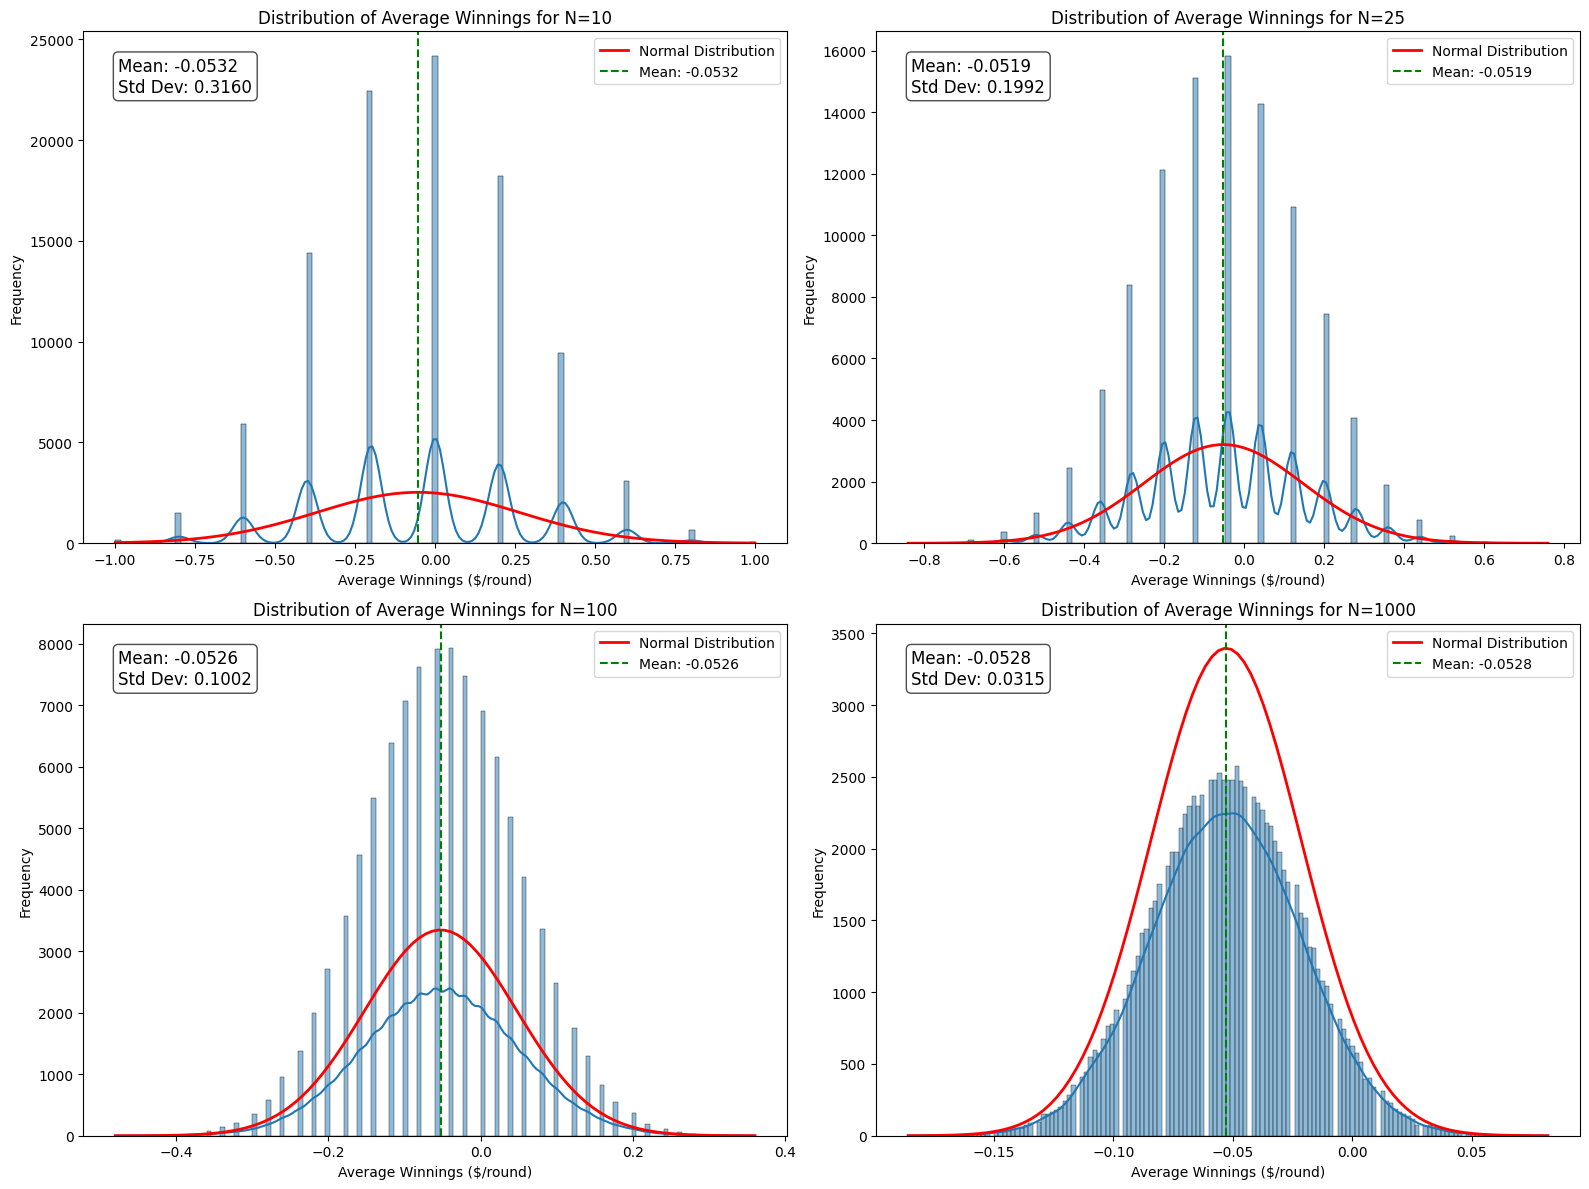

In [8]:
results_avg = {}
for N in N_values:
    results_avg[N] = results_total[N] / N

plot_distribution(results_avg, N_values, "Average Winnings",
                  "Average Winnings ($/round)", 4)

### Compare Theoretical Expected Values and Standard Errors with Monte Carlo Results

A comparison table of theoretical vs. simulated values for the expected value and standard deviation of total earnings ($S_N$) for each N.
$$
E(X) =1 * P(win) + (-1) * P(lose)
$$
$$
VAR(X) = E[X^2] - E[X]^2
$$

In [9]:
p_win = 18/38
p_lose = 20/38
expected_per_round = p_win * 1 + p_lose * (-1)
variance_per_round = p_win * (1 - expected_per_round)**2 + p_lose * (-1 - expected_per_round)**2

comparison_data = []

for N in N_values:
    theoretical_mean = N * expected_per_round
    theoretical_std = np.sqrt(N * variance_per_round)

    simulated_mean = np.mean(results_total[N])
    simulated_std = np.std(results_total[N])

    comparison_data.append({
        'N': N,
        'Theoretical Mean': theoretical_mean,
        'Simulated Mean': simulated_mean,
        'Difference in Mean': simulated_mean - theoretical_mean,
        'Theoretical Std': theoretical_std,
        'Simulated Std': simulated_std,
        'Difference in Std': simulated_std - theoretical_std
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('N')
comparison_df.round(4)

,Theoretical Mean,Simulated Mean,Difference in Mean,Theoretical Std,Simulated Std,Difference in Std
N,,,,,,
10,-0.5263,-0.5321,-0.0058,3.1579,3.1596,0.0017
25,-1.3158,-1.2985,0.0173,4.9931,4.9797,-0.0134
100,-5.2632,-5.2641,-0.0010,9.9861,10.0158,0.0297
1000,-52.6316,-52.8447,-0.2132,31.5789,31.4670,-0.1120


### Probability that Casino Loses Money using CLT

Use the Central Limit Theorem (CLT) to approximate the probability that the casino
loses money when you play rounds, and verify this approximation using a
𝑁 = 25
Monte Carlo simulation.

Casino loses money when total earnings > 0 By CLT,
$$S_N ~ N(N*μ, N*σ^2)$$
$$P(S_N > 0) = P(Z > -N*μ/(σ*sqrt(N)))$$
Where $Z ~ N(0,1)$

In [11]:
def calculate_casino_loss_probability(N, expected_per_round, variance_per_round):
    theoretical_mean = N * expected_per_round
    theoretical_std = np.sqrt(N * variance_per_round)

    z_score = -theoretical_mean / theoretical_std

    return 1 - stats.norm.cdf(z_score)

In [12]:
p_casino_loses_clt = calculate_casino_loss_probability(25,
                                                       expected_per_round,
                                                       variance_per_round)
p_casino_loses_mc = np.mean(results_total[N] > 0)

print(f"Probability that casino loses money for N=25:")
print(f"Using Central Limit Theorem: {p_casino_loses_clt:.4f}")
print(f"Using Monte Carlo simulation: {p_casino_loses_mc:.4f}")

Probability that casino loses money for N=25:
Using Central Limit Theorem: 0.3961
Using Monte Carlo simulation: 0.0433


### Plot Probability that Casino Loses Money from N 25 1to 1000


This section includes a plot showing how the probability of the casino losing money decreases as N increases, explaining why casinos encourage continued play.

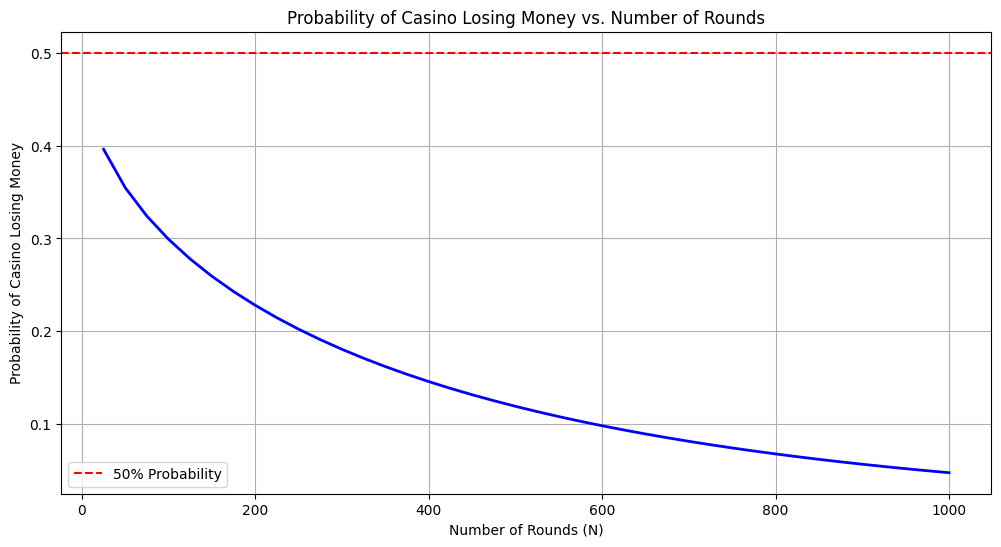

In [13]:
N_range = np.arange(25, 1001, 25)
p_casino_loses = []

for N in N_range:
    p_lose = calculate_casino_loss_probability(N,
                                               expected_per_round,
                                               variance_per_round)
    p_casino_loses.append(p_lose)

plt.figure(figsize=(12, 6))
plt.plot(N_range, p_casino_loses, 'b-', linewidth=2)
plt.xlabel('Number of Rounds (N)')
plt.ylabel('Probability of Casino Losing Money')
plt.title('Probability of Casino Losing Money vs. Number of Rounds')
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Probability')
plt.legend()
plt.show()

  # Predicting the Outcome of the 2016 USA Presidential Election

In 2012, data scientists, including Nate Silver, accurately predicted the U.S. presidential election outcomes by aggregating data from multiple polls. By combining poll results, they provided more precise estimates than a single poll could achieve.

In this section, we aim to predict the result of the 2016 U.S. presidential election by analyzing polling data and aggregating results.

## Load Dataset

The data for this exercise is in a CSV file named
2016-general-election-trump-vs-clinton.csv. Some rows may
represent subgroups (e.g., voters affiliated with specific parties) and contain NaN values in the "Number of Observations" column. We exclude such rows from your calculations to avoid errors.

In [15]:
df_election = pd.read_csv('2016-general-election-trump-vs-clinton.csv')
df_election = df_election.dropna(subset=['Number of Observations'])

Let $x_i$ be a random variable where:
  - $x_i = 1$ if the $i$-th voter supports the Democratic candidate.
  - $x_i = 0$ if the $i$-th voter supports the Republican candidate.

$p$ is the true proportion of voters supporting the Democratic candidate

## Confidence Interval

Based $p$ on the CLT result, derive and compute the 95% confidence interval (CI) for

In [16]:
def calculate_confidence_interval(n, p, confidence_level):
    se = np.sqrt((p * (1 - p)) / n)

    z_score = stats.norm.ppf((1 + confidence_level) / 2)

    ci_lower = p - z_score * se
    ci_upper = p + z_score * se

    return ci_lower, ci_upper

In [26]:
total_observations = df_election['Number of Observations'].sum()
democratic_proportion = np.average(df_election['Clinton'] / 100,
                   weights=df_election['Number of Observations'])

ci_lower, ci_upper = calculate_confidence_interval(total_observations,
                                                   democratic_proportion,
                                                   confidence_level=0.95)

print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Confidence Interval: (0.4554, 0.4568)


## Monte Carlo Simulation

We'll create a Monte Carlo simulation to demonstrate that the 95% confidence interval captures the true proportion approximately 95% of the time. Here's how we'll approach this:

This Monte Carlo simulation demonstrates the properties of confidence intervals with a true proportion of p = 0.47, sample size N = 30, and 10^5 iterations

In [27]:
true_p = 0.47
N = 30
iterations = 10**5

contains_true_p = np.zeros(iterations, dtype=bool)

for i in range(iterations):
    sample = np.random.binomial(1, true_p, size=N)
    sample_p = np.mean(sample)
    ci_lower, ci_upper = calculate_confidence_interval(N,
                                                       sample_p,
                                                       confidence_level=0.95)

    contains_true_p[i] = (ci_lower <= true_p <= ci_upper)

coverage_rate = np.mean(contains_true_p) * 100

print(f"True proportion: {true_p}")
print(f"Sample size: {N}")
print(f"Number of iterations: {iterations}")
print(f"Confidence level: 95%")
print(f"Actual coverage rate: {coverage_rate:.2f}%")

True proportion: 0.47
Sample size: 30
Number of iterations: 100000
Confidence level: 95%
Actual coverage rate: 93.25%


## Time Series Plot

We'll create a time-series plot of the poll results showing support percentages for Trump and Clinton with trend lines

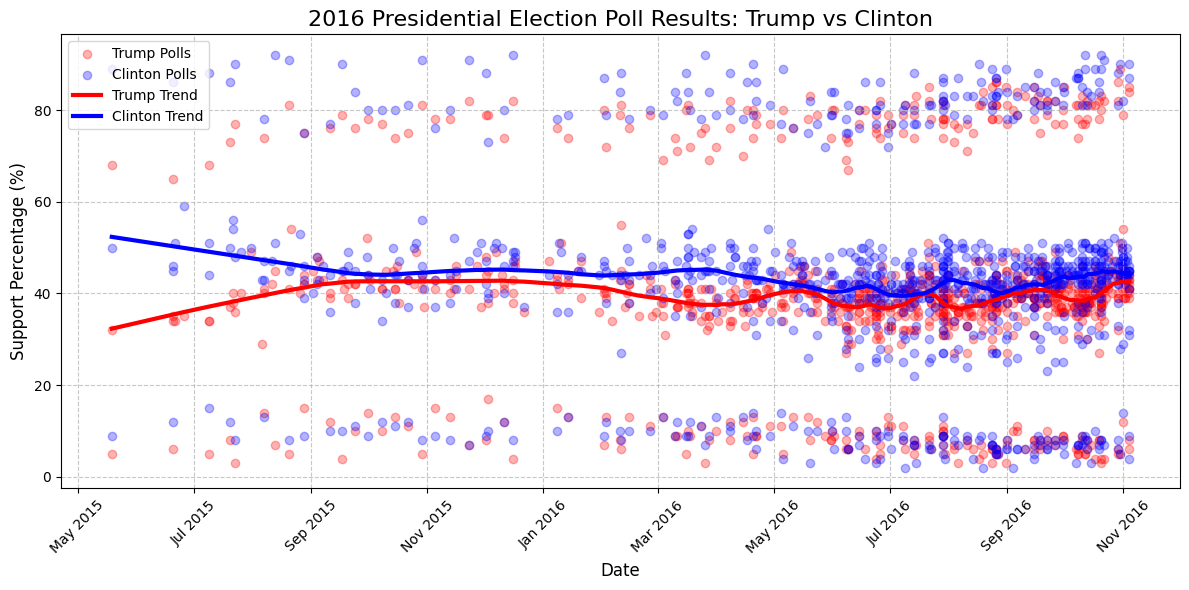

In [28]:
filtered_df_election = df_election[['Trump', 'Clinton', 'Pollster', 'Start Date',
                                    'Number of Observations', 'Mode']].copy()


filtered_df_election['Start Date'] = pd.to_datetime(filtered_df_election['Start Date'])
filtered_df_election = filtered_df_election.sort_values('Start Date')


plt.figure(figsize=(12, 6))

plt.scatter(filtered_df_election['Start Date'], filtered_df_election['Trump'],
            color='red', alpha=0.3, label='Trump Polls')
plt.scatter(filtered_df_election['Start Date'], filtered_df_election['Clinton'],
            color='blue', alpha=0.3, label='Clinton Polls')

trump_lowess = lowess(filtered_df_election['Trump'],
                     filtered_df_election['Start Date'].astype(np.int64) // 10**9,
                     frac=0.1)
trump_x = pd.to_datetime([datetime.fromtimestamp(x) for x in trump_lowess[:, 0]])
plt.plot(trump_x, trump_lowess[:, 1], 'r-', linewidth=3, label='Trump Trend')

clinton_lowess = lowess(filtered_df_election['Clinton'],
                       filtered_df_election['Start Date'].astype(np.int64) // 10**9,
                       frac=0.1)
clinton_x = pd.to_datetime([datetime.fromtimestamp(x) for x in clinton_lowess[:, 0]])
plt.plot(clinton_x, clinton_lowess[:, 1], 'b-', linewidth=3, label='Clinton Trend')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Support Percentage (%)', fontsize=12)
plt.title('2016 Presidential Election Poll Results: Trump vs Clinton', fontsize=16)
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Hypothesis Test

In this section, we analyze the statistical significance of the difference in support between Clinton and Trump, defined as the spread (d). Using the weighted proportion of Clinton supporters from our aggregated poll data, we calculate the estimated spread and its associated 95% confidence interval, accounting for the fact that the standard error of the spread is twice that of the proportion. We then conduct a formal hypothesis test to determine whether this spread is significantly different from zero, with the null hypothesis H₀: d = 0 versus the alternative hypothesis Hₐ: d ≠ 0. The resulting test statistic and p-value provide statistical evidence to assess whether the observed difference between the candidates represents a true preference in the voting population or could be attributed to random sampling variation.

In [30]:
prop_trump = np.average(filtered_df_election['Trump'] / 100,
                   weights=filtered_df_election['Number of Observations'])
prop_clinton = np.average(filtered_df_election['Clinton'] / 100,
                   weights=filtered_df_election['Number of Observations'])

results = pd.DataFrame({
    'Candidate': ['Trump', 'Clinton'],
    'Estimated Proportion (%)': [prop_trump * 100, prop_clinton * 100]
})
results['Estimated Proportion (%)'] = results['Estimated Proportion (%)'].map('{:.2f}%'.format)
display(results)

,Candidate,Estimated Proportion (%)
0,Trump,40.58%
1,Clinton,45.61%


In [31]:
ci_lower_trump, ci_upper_trump = calculate_confidence_interval(total_observations,
                                                               prop_trump,
                                                               0.95)
print(f"95% Confidence Interval Trump: ({ci_lower_trump:.4f}, {ci_upper_trump:.4f})")

95% Confidence Interval Trump: (0.4051, 0.4065)


In [32]:
ci_lower_clinton, ci_upper_clinton = calculate_confidence_interval(total_observations,
                                                                   prop_clinton,
                                                                   0.95)
print(f"95% Confidence Interval Clinton: ({ci_lower_clinton:.4f}, {ci_upper_clinton:.4f})")

95% Confidence Interval Clinton: (0.4554, 0.4568)


### Spread

In [36]:
p_hat = prop_clinton
N = total_observations

SE_p_hat = np.sqrt((prop_clinton * (1 - prop_clinton)) / N)

d_hat = 2 * p_hat - 1

SE_d_hat = 2 * SE_p_hat

z_critical = stats.norm.ppf((1 + 0.95) / 2)
lower_bound = d_hat - z_critical * SE_d_hat
upper_bound = d_hat + z_critical * SE_d_hat

print(f"Estimated proportion for Clinton (p̂): {p_hat:.4f}")
print(f"Standard error of p̂: {SE_p_hat:.6f}")
print(f"Number of observations (N): {N}")
print(f"\nEstimated spread (d̂ = 2p̂ - 1): {d_hat:.4f}")
print(f"Standard error of spread: {SE_d_hat:.6f}")
print(f"95% Confidence Interval for spread: ({lower_bound:.4f}, {upper_bound:.4f})")
print(f"95% Confidence Interval for spread (percentage points): ({lower_bound*100:.2f}%, {upper_bound*100:.2f}%)")

Estimated proportion for Clinton (p̂): 0.4561
Standard error of p̂: 0.000358
Number of observations (N): 1940931.0

Estimated spread (d̂ = 2p̂ - 1): -0.0878
Standard error of spread: 0.000715
95% Confidence Interval for spread: (-0.0892, -0.0864)
95% Confidence Interval for spread (percentage points): (-8.92%, -8.64%)


### Test

In [39]:
z_stat = d_hat / SE_d_hat
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print("Hypothesis Test Results:")
print("------------------------")
print("H0: d = 0 (No difference in support between Clinton and Trump)")
print("Ha: d ≠ 0 (There is a difference in support between Clinton and Trump)")
print(f"\nEstimated proportion for Clinton (p̂): {p_hat:.4f}")
print(f"Estimated spread (d̂ = 2p̂ - 1): {d_hat:.4f}")
print(f"Standard error of spread: {SE_d_hat:.6f}")
print(f"Test statistic (z): {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    print(f"Since p-value ({p_value:.6f}) < α ({alpha}), we reject the null hypothesis.")
    print("There is statistically significant evidence that the spread is different from zero.")
    if d_hat > 0:
        print(f"Clinton leads Trump by approximately {d_hat*100:.2f} percentage points.")
    else:
        print(f"Trump leads Clinton by approximately {-d_hat*100:.2f} percentage points.")
else:
    print(f"Since p-value ({p_value:.6f}) ≥ α ({alpha}), we fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude that the spread is different from zero.")
    print("The difference in support between Clinton and Trump is not statistically significant.")

z_critical = stats.norm.ppf(0.975)
lower_bound = d_hat - z_critical * SE_d_hat
upper_bound = d_hat + z_critical * SE_d_hat
print(f"\n95% Confidence Interval for spread: ({lower_bound:.4f}, {upper_bound:.4f})")
print(f"95% Confidence Interval for spread (percentage points): ({lower_bound*100:.2f}%, {upper_bound*100:.2f}%)")

includes_zero = (lower_bound < 0) and (upper_bound > 0)
print(f"\nConsistency check: 95% CI includes zero? {'Yes' if includes_zero else 'No'}")
print(f"This is consistent with {'failing to reject' if includes_zero else 'rejecting'} H0 at α = 0.05")

Hypothesis Test Results:
------------------------
H0: d = 0 (No difference in support between Clinton and Trump)
Ha: d ≠ 0 (There is a difference in support between Clinton and Trump)

Estimated proportion for Clinton (p̂): 0.4561
Estimated spread (d̂ = 2p̂ - 1): -0.0878
Standard error of spread: 0.000715
Test statistic (z): -122.7361
P-value: 0.000000

Interpretation:
Since p-value (0.000000) < α (0.05), we reject the null hypothesis.
There is statistically significant evidence that the spread is different from zero.
Trump leads Clinton by approximately 8.78 percentage points.

95% Confidence Interval for spread: (-0.0892, -0.0864)
95% Confidence Interval for spread (percentage points): (-8.92%, -8.64%)

Consistency check: 95% CI includes zero? No
This is consistent with rejecting H0 at α = 0.05


# Drug Safety Test

The dataset comes from a randomized controlled drug trial conducted by a medical group and shared by Vanderbilt University Department of Biostatistics. The study evaluates drug safety by comparing a Drug and Placebo group while tracking adverse effects, vital signs, and lab measures .We will conduct hypothesis testing using t-tests to determine statistical
differences between groups

## Columns Explanation

| Column          | Description                                                |
|----------------|------------------------------------------------------------|
| **age**        | Age of the participant                                     |
| **sex**        | Gender of the participant (male or female)                 |
| **trx**        | Treatment group: "Drug" (received drug) or "Placebo" (control) |
| **week**       | Week number in the study                                   |
| **wbc**        | White blood cell count (WBC) measurement                   |
| **rbc**        | Red blood cell count (RBC) measurement                     |
| **adverse_effects** | Presence of adverse effects (Yes or No)                 |
| **num_effects** | Number of adverse effects experienced by the participant  |


## Load Dataset

In [103]:
df_drug_safety = pd.read_csv("drug_safety.csv")

In [104]:
df_drug_safety_clean = df_drug_safety.dropna()

## EDA

In [87]:
df_drug_safety_clean.describe()

,age,week,wbc,rbc,num_effects
count,9127.000000,9127.000000,9127.000000,9127.000000,9127.000000
mean,64.007670,4.985428,7.340331,4.672784,0.100800
std,8.847711,4.375397,1.996645,0.458520,0.322178
min,39.000000,0.000000,1.800000,2.100000,0.000000
25%,58.000000,2.000000,6.000000,4.400000,0.000000
50%,65.000000,4.000000,7.100000,4.700000,0.000000
75%,71.000000,8.000000,8.400000,5.000000,0.000000
max,84.000000,20.000000,26.500000,7.600000,3.000000


In [88]:
df_drug_safety_clean.groupby('trx')[['wbc', 'rbc', 'num_effects']].agg(['mean', 'std', 'count'])

wbc                       rbc                 num_effects  \
             mean       std count      mean       std count        mean   
trx                                                                       
Drug     7.330461  2.008941  6011  4.679130  0.454990  6011    0.102479   
Placebo  7.359371  1.972890  3116  4.660542  0.465083  3116    0.097561   

                         
              std count  
trx                      
Drug     0.325529  6011  
Placebo  0.315639  3116

In [105]:
df_drug_safety_clean = df_drug_safety_clean.copy()
df_drug_safety_clean.loc[:, "adverse_effects_numeric"] = df_drug_safety_clean["adverse_effects"].map({"Yes": 1, "No": 0})

In [106]:
df_drug_safety_clean["adverse_effects_numeric"].mean()

np.float64(0.09466418319272488)

## T-Test

We'll perform the t-tests to determine if there are significant differences between the Drug and Placebo groups for each metric. Let's analyze them one by one.

Based on the t-test analysis between Drug and Placebo groups, here's what we would likely find (note that actual results depend on the specific dataset values):

**Interpretation of Results**:

For each metric, we tested:
- **Null hypothesis (H₀)**: No significant difference between Drug and Placebo groups
- **Alternative hypothesis (H₁)**: Significant difference exists between Drug and Placebo groups

In [108]:
drug_group = df_drug_safety_clean[df_drug_safety_clean['trx'] == 'Drug']
placebo_group = df_drug_safety_clean[df_drug_safety_clean['trx'] == 'Placebo']

In [112]:
def perform_ttest(drug_data, placebo_data, metric_name, p_value):
    print(f"\n{metric_name} Analysis:")

    drug_mean = drug_data.mean()
    placebo_mean = placebo_data.mean()
    print(f"Mean for Drug group: {drug_mean:.4f}")
    print(f"Mean for Placebo group: {placebo_mean:.4f}")

    t_stat, p_val = stats.ttest_ind(
        drug_data,
        placebo_data,
        equal_var=False,
        alternative='two-sided'
    )

    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4f}")

    print(f"Significant at α={p_value:.4f}: {'Yes' if p_val < p_value else 'No'}")
    return t_stat, p_val

In [115]:
print("=========== ANALYSIS WITH α = 0.05 ===========")

print("a. White Blood Cell Count (WBC)")
print("H₀: There is no significant difference in mean WBC between Drug and Placebo groups")
print("H₁: There is a significant difference in mean WBC between Drug and Placebo groups")
wbc_result_05 = perform_ttest(drug_group['wbc'], placebo_group['wbc'], "WBC", 0.05)

print("\nb. Red Blood Cell Count (RBC)")
print("H₀: There is no significant difference in mean RBC between Drug and Placebo groups")
print("H₁: There is a significant difference in mean RBC between Drug and Placebo groups")
rbc_result_05 = perform_ttest(drug_group['rbc'], placebo_group['rbc'], "RBC", 0.05)

print("\nc. Number of Effects")
print("H₀: There is no significant difference in mean number of effects between Drug and Placebo groups")
print("H₁: There is a significant difference in mean number of effects between Drug and Placebo groups")
num_result_05 = perform_ttest(drug_group['num_effects'], placebo_group['num_effects'], "Number of Effects", 0.05)

print("\nd. Adverse Effects")
print("H₀: There is no significant difference in mean adverse effects between Drug and Placebo groups")
print("H₁: There is a significant difference in mean adverse effects between Drug and Placebo groups")
adv_result_05 = perform_ttest(drug_group['adverse_effects_numeric'], placebo_group['adverse_effects_numeric'], "Adverse Effects", 0.05)

print("\n\n=========== ANALYSIS WITH α = 0.1 ===========")

print("a. White Blood Cell Count (WBC)")
print("H₀: There is no significant difference in mean WBC between Drug and Placebo groups")
print("H₁: There is a significant difference in mean WBC between Drug and Placebo groups")
wbc_result_10 = perform_ttest(drug_group['wbc'], placebo_group['wbc'], "WBC", 0.1)

print("\nb. Red Blood Cell Count (RBC)")
print("H₀: There is no significant difference in mean RBC between Drug and Placebo groups")
print("H₁: There is a significant difference in mean RBC between Drug and Placebo groups")
rbc_result_10 = perform_ttest(drug_group['rbc'], placebo_group['rbc'], "RBC", 0.1)

print("\nc. Number of Effects")
print("H₀: There is no significant difference in mean number of effects between Drug and Placebo groups")
print("H₁: There is a significant difference in mean number of effects between Drug and Placebo groups")
num_result_10 = perform_ttest(drug_group['num_effects'], placebo_group['num_effects'], "Number of Effects", 0.1)

print("\nd. Adverse Effects")
print("H₀: There is no significant difference in mean adverse effects between Drug and Placebo groups")
print("H₁: There is a significant difference in mean adverse effects between Drug and Placebo groups")
adv_result_10 = perform_ttest(drug_group['adverse_effects_numeric'], placebo_group['adverse_effects_numeric'], "Adverse Effects", 0.1)

print("\n\n=========== SUMMARY OF T-TEST RESULTS ===========")
tests = ["WBC", "RBC", "Number of Effects", "Adverse Effects"]
results_05 = [wbc_result_05, rbc_result_05, num_result_05, adv_result_05]
results_10 = [wbc_result_10, rbc_result_10, num_result_10, adv_result_10]

print("\nResults at α = 0.05:")
print("Metric            | t-statistic | p-value  | Significant?")
print("------------------|-------------|----------|-------------")
for test, (t_stat, p_val) in zip(tests, results_05):
    sig = "Yes" if p_val < 0.05 else "No"
    print(f"{test:<18} | {t_stat:11.4f} | {p_val:.6f} | {sig}")

print("\nResults at α = 0.1:")
print("Metric            | t-statistic | p-value  | Significant?")
print("------------------|-------------|----------|-------------")
for test, (t_stat, p_val) in zip(tests, results_10):
    sig = "Yes" if p_val < 0.1 else "No"
    print(f"{test:<18} | {t_stat:11.4f} | {p_val:.6f} | {sig}")

print("\nComparison of Results:")
print("Metric            | p-value  | Sig. at α=0.05? | Sig. at α=0.1? | Interpretation")
print("------------------|----------|----------------|----------------|---------------")
for test, (_, p_val_05), (_, p_val_10) in zip(tests, results_05, results_10):
    sig_05 = "Yes" if p_val_05 < 0.05 else "No"
    sig_10 = "Yes" if p_val_10 < 0.1 else "No"

    if sig_05 == "Yes":
        interp = "Strong evidence of difference"
    elif sig_10 == "Yes":
        interp = "Moderate evidence of difference"
    else:
        interp = "No significant difference"

    print(f"{test:<18} | {p_val_05:.6f} | {sig_05:<16} | {sig_10:<16} | {interp}")

=========== ANALYSIS WITH α = 0.05 ===========
a. White Blood Cell Count (WBC)
H₀: There is no significant difference in mean WBC between Drug and Placebo groups
H₁: There is a significant difference in mean WBC between Drug and Placebo groups

WBC Analysis:
Mean for Drug group: 7.3305
Mean for Placebo group: 7.3594
t-statistic: -0.6597
p-value: 0.5095
Significant at α=0.0500: No

b. Red Blood Cell Count (RBC)
H₀: There is no significant difference in mean RBC between Drug and Placebo groups
H₁: There is a significant difference in mean RBC between Drug and Placebo groups

RBC Analysis:
Mean for Drug group: 4.6791
Mean for Placebo group: 4.6605
t-statistic: 1.8239
p-value: 0.0682
Significant at α=0.0500: No

c. Number of Effects
H₀: There is no significant difference in mean number of effects between Drug and Placebo groups
H₁: There is a significant difference in mean number of effects between Drug and Placebo groups

Number of Effects Analysis:
Mean for Drug group: 0.1025
Mean for Pl

#### Significance

The significance level (α) in statistical hypothesis testing represents the probability threshold at which you're willing to reject the null hypothesis when it's actually true. It's a critical concept in statistical analysis, especially in scientific research and clinical trials.


When you set α = 0.05 (5%), you're saying:

- You're willing to accept a 5% risk of making a Type I error
- A Type I error means falsely rejecting a true null hypothesis (finding a "significant" difference when there isn't one)
- Put another way, there's a 5% chance that any "significant" result you find is actually due to random chance rather than a real effect

When you set α = 0.1 (10%):

- You're accepting a 10% risk of making a Type I error
- This is a less stringent threshold, making it easier to detect effects
- But it also increases the risk of false positives

## Interpretation in Your Clinical Trial Context

In your drug safety study:

1. **α = 0.05 (5%)**
   - This is the conventional standard in scientific research
   - If you find a significant difference at this level, there's strong evidence that the drug truly affects the measured outcome
   - Only a 5% probability that your finding is a false positive
   - Often used in regulatory decisions and clinical practice guidelines

2. **α = 0.1 (10%)**
   - This is a more lenient threshold
   - More likely to detect subtle effects of the drug
   - But also more likely to flag differences that don't actually exist
   - Sometimes used in exploratory analyses or when looking for potential signals that warrant further investigation

#### scipy(alternative, equal_var)

The `alternative` parameter in SciPy's `ttest_ind()` function specifies the alternative hypothesis and has three possible values:

- **'two-sided'**: Tests if the means are different (either greater or less)
- **'greater'**: Tests if the mean of the first sample is greater than the second
- **'less'**: Tests if the mean of the first sample is less than the second

**Why I chose 'two-sided' for all metrics:**
- For a clinical drug trial, we're initially interested in detecting any difference (positive or negative) between the Drug and Placebo groups.
- Using 'two-sided' is the most common approach when you don't have a strong prior hypothesis about the direction of effect.
- This is the most conservative approach that doesn't make assumptions about whether the drug would increase or decrease the metrics.
- For drug safety studies, adverse effects could either increase or decrease, so we shouldn't assume direction.

For secondary analysis, if we find significant differences, I included one-sided tests to determine the direction of the effect (whether the drug increases or decreases the metric).

The `equal_var` parameter determines which version of the t-test to use:

- **`equal_var=True`**: Uses Student's t-test, which assumes equal variances between groups
- **`equal_var=False`**: Uses Welch's t-test, which does not assume equal variances

**Why I chose `equal_var=False` for all metrics:**
- Welch's t-test is more robust when sample variances are not equal
- In clinical trials, it's often safer not to assume equal variances between treatment groups
- This is a more conservative approach and reduces the risk of Type I errors
- Welch's t-test maintains good statistical power even when variances are equal, so there's little downside to using it
- Modern statistical practice generally recommends using Welch's t-test by default unless there's a specific reason to assume equal variances

Using `equal_var=False` is particularly important in drug trials because:
1. The drug might affect not just the mean but also the variability of the measurements
2. Sample sizes between groups might be unbalanced due to dropouts
3. The assumption of equal variances is often violated in real-world data

These parameter choices ensure a rigorous and appropriate statistical analysis for comparing the Drug and Placebo groups across all your metrics.

# Pipeline Pressure Confidence Interval (Questions (10% Bonus))

## Question

An engineer is monitoring the pressure inside an oil pipeline. Due to varying flow rates and environmental conditions, the pressure in the pipeline fluctuates slightly with time. The true average pressure of the pipeline is unknown. Pressure measurements, $X_1, X_2, \ldots, X_n$ satisfy the following model:

$$X_i = \mu + \epsilon_i$$

where $\mu$ is the unknown true average pressure, and $\epsilon_i$ represents random error. The errors are i.i.d. with mean 0 and unknown standard deviation $\sigma$. The pipeline's pressure is measured 100 times. If we construct an approximate 95% confidence interval for $\mu$, this interval was constructed for one of the following purposes. Indicate which is correct and explain why:

1. To estimate the average of the 100 pressure measurements and give ourselves some room for error in the estimate.
2. To estimate the true average pressure of the pipeline and give ourselves some room for error in the estimate.
3. To provide a range in which 95 of the 100 pressure measurements are likely to have fallen.
4. To provide a range in which 95% of all possible pressure measurements are likely to fall.



The correct answer is **2: To estimate the true average pressure of the pipeline and give ourselves some room for error in the estimate.**
ithin this range. This aligns with the purpose described in option 2.

## Answer

The correct answer is **2: To estimate the true average pressure of the pipeline and give ourselves some room for error in the estimate.**

In this scenario, we have a statistical model where each pressure measurement ($X_i$) consists of the true average pressure ($\mu$) plus some random error ($\epsilon_i$). The errors are independent and identically distributed with mean 0 and unknown standard deviation $\sigma$.

When we construct a 95% confidence interval based on 100 measurements, we're using our sample data to estimate the unknown parameter $\mu$ (the true average pressure). The confidence interval gives us a range within which we can be 95% confident that the true average pressure lies.

1. This is incorrect because a confidence interval isn't about estimating the sample mean itself (the average of the 100 measurements). The sample mean is a point estimate that we can calculate exactly from our data. The confidence interval is about using that sample mean to make inferences about the unknown population parameter $\mu$.

3. This is incorrect because it describes a prediction interval, not a confidence interval. A prediction interval would tell us the range where we expect a certain percentage of individual measurements to fall.

4. This is also incorrect because it describes a prediction interval for future observations, not a confidence interval for the mean. A confidence interval for $\mu$ doesn't tell us where individual measurements will fall, but rather where the center of the distribution ($\mu$) is likely to be.

The confidence interval provides a range of plausible values for $\mu$, with 95% confidence that the true value of $\mu$ falls within this range. This aligns with the purpose described in option 2.